In [1]:
import pandas as pd
from pathlib import Path
import inspect 
import numpy as np
import datetime
import os
import json
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from dotmap import DotMap
import torch
import torch.nn.init as init
import torch.nn as nn
import pickle
import torch.autograd as autograd
from torchviz import make_dot
from torchsummary import summary
from termcolor import colored
import seaborn as sns
sns.set()


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
reserved = int(torch.cuda.max_memory_reserved() / 1000 / 1000)
gpu_available = torch.cuda.is_available()

print(colored(f"GPU available! {torch.cuda.get_device_name()}. Memory reserved: {reserved}MB", "green") if gpu_available else colored("No GPU. Running on CPU", "red"))

GPU available! NVIDIA GeForce RTX 3060. Memory reserved: 0MB


## Research Notes and Progress

**Current Status**
1. Should we do $X_{t0} \rightarrow NEE_{t1}$ instead of current $X_{t0} \rightarrow NEE_{t0}$ and see if we beat RFR at this
2. MSE experiments
3. Architecture experiments

In [3]:
timestamp = datetime.datetime.now()
timestamp = f"{timestamp.year}-{timestamp.month}-{timestamp.day}_{timestamp.hour}-{timestamp.minute}-{timestamp.second}-{timestamp.microsecond}"

save_dir = Path(timestamp)
if save_dir.exists():
    raise f"Directory exists: {save_dir.as_posix()}"
os.makedirs(save_dir.as_posix())

In [4]:
config = DotMap({"flux_model": "night"})

In [5]:
writer = SummaryWriter(save_dir.joinpath("tensorboard"))

## Model Building and Training

### Data

In [6]:
data = pd.read_parquet("../data_manipulation/final_night_data.parquet")

In [7]:
def set_season_tag(df, isnorth = True):
    if isnorth:
        df["season"] = (df['DateTime'].dt.month%12 + 3) // 3 # print(seasons)
    else:
        df["season"] = ((df['DateTime'].dt.month + 6)%12 + 3)//3
    return df, "season"

def extract_time_features(df):
    """
    Extract features from the timestamp for model training.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    
    Returns:
    pd.DataFrame: DataFrame with extracted features, list: features added to dataframe
    """
    df = df.copy()
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    return df, ["hour", "dayofweek", "month", "dayofyear"]
    
def split_data(df, test_size=0.2):
    """
    Split data into training and test sets.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    test_size (float): Proportion of the data to include in the test split.
    
    Returns:
    tuple: Training and test DataFrames.
    """
    train_data, test_data = train_test_split(df, test_size=test_size, shuffle=False)
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [8]:
drivers = np.array(['Ta', 'H', 'Tau', 'LE_strg', 'RH', 'VPD', 'Rg', 'Ustar', 'Tsoil1', 'Tsoil2'])

In [9]:
data, season_feat = set_season_tag(data)
data, time_feat = extract_time_features(data)

In [10]:
data = data[data["dNEE"].notna()].reset_index(drop=True)

In [11]:
data.shape

(21639, 74)

In [12]:
drivers = np.concatenate([drivers, [season_feat], time_feat])

In [13]:
columns_to_check_na = np.concatenate([drivers, ["NEE", "dTa"]])

idx = (np.sum(data[columns_to_check_na].notna(), axis=1) == columns_to_check_na.shape[0])
data = data.loc[idx].reset_index(drop=True)

### Training Data 

In [14]:
train_data, test_data = split_data(data)

In [15]:
X_train = train_data[drivers]
NEE_train = train_data["NEE"]
dT_train = train_data["dTa"]
dNEE_train = train_data["dNEE"]
K_train = train_data[["E0", "rb"]]

X_test = test_data[drivers]
NEE_test = test_data["NEE"]
dT_test = test_data["dTa"]
dNEE_test = test_data["dNEE"]
K_test = test_data[["E0", "rb"]]


In [16]:
normalizer = StandardScaler()

X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

In [17]:
with open(save_dir.joinpath("normalizer.pickle"), "wb") as fp:
    pickle.dump(normalizer, fp)

In [19]:
config.data.X = drivers.tolist()
config.data.train_size = X_train.shape[0]
config.data.train_start_date = train_data["DateTime"].iloc[0].ctime()
config.data.train_end_date = train_data["DateTime"].iloc[-1].ctime()
config.data.test_size = X_test.shape[0]
config.data.test_start_date = test_data["DateTime"].iloc[0].ctime()
config.data.test_end_date = test_data["DateTime"].iloc[-1].ctime()


### Model Building

In [20]:
def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        # Apply He initialization
        init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
        init.zeros_(layer.bias)

In [21]:
class PIVAE_SDE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim, activation=nn.Tanh):
        super(PIVAE_SDE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.activation = activation
        self.Tref = torch.tensor(10).to("cuda")
        self.T0 = torch.tensor(46.02).to("cuda")
        self.hidden_dims = hidden_dims
        
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, latent_dim)
        )
        
        # Decoder network for NEE (u)
        self.nee_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, 1)  # Output NEE (u)
        )
        
        # Decoder network for dT/dt (f)
        self.temp_derivative_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, 1)  # Output dT/dt
        )
        
        # Decoder network for E0 and rb (k)
        self.k_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, 2)  # Output E0 and rb
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x, f, k):
        input_ = torch.cat((x, f.view(x.shape[0], 1), k), dim=1).to("cuda")
        z = self.encoder(input_)
        nee = self.nee_decoder(z)
        dT_dt = self.temp_derivative_decoder(z)
        k = self.k_decoder(z)
        f, residual = self.physics_residual(nee, x, k, x[:, 0].view((-1, 1)), dT_dt)
        
        return nee, dT_dt, k, f, z, residual

    def physics_residual(self, nee, x, k, T, dT_dt):
        E0 = k[:, 0].view((-1, 1))
        rb = k[:, 1].view((-1, 1))
        
        # Compute dNEE/dT using predicted E0 and rb
        exp_term = torch.exp(E0 * (1.0 / (self.Tref - self.T0) - 1.0 / (T - self.T0))).view((-1, 1))
        dNEE_dT = rb * (E0 / (T - self.T0)**2) * exp_term

        # Physics-based residual f = dNEE/dt - (dNEE/dT) * (dT/dt)
        #f_residual = autograd.grad(nee, x, grad_outputs=torch.ones_like(nee), create_graph=True)[:, 0]
        residual = torch.zeros_like(nee) #f_residual - dNEE_dT * dT_dt
 
        f = dNEE_dT * dT_dt
        
        return f, residual
        # Incorporate boundary condition (NEE_t should be close to NEE_{t-1})

In [22]:
def loss_function(nee_pred, nee_true, latent, z_prior, temp_pred, temp_true, E0_rb_pred, E0_rb_true, f_pred, f_true, physics_residual, mmd_loss_fn):
    # MMD Loss for NEE (u)
    mmd_loss_nee = mmd_loss_fn(nee_pred, nee_true) + mmd_loss_fn(latent, z_prior)

    # MMD Loss for dNEE (f)
    mmd_f_loss = mmd_loss_fn(f_pred, f_true)
    
    # MMD Loss for E0 and rb (k)
    E0_pred, rb_pred = E0_rb_pred[:, 0], E0_rb_pred[:, 1]
    E0_true, rb_true = E0_rb_true[:, 0], E0_rb_true[:, 1]

    mmd_loss_E0 = mmd_loss_fn(E0_pred.view((-1, 1)), E0_true.view((-1, 1)))
    mmd_loss_rb = mmd_loss_fn(rb_pred.view((-1, 1)), rb_true.view((-1, 1)))
    
    # MMD loss for temperature derivative (f)
    mmd_temp_loss = mmd_loss_fn(temp_pred.view((-1, 1)), temp_true.view((-1, 1)))
    
    # Physics-based loss (ensure the solution satisfies the physics model)
    physics_loss = torch.mean(physics_residual ** 2)
    
    # Total loss
    # total_loss = mmd_loss_nee + mmd_loss_E0 + mmd_loss_rb + mmd_temp_loss + physics_loss + mmd_f_loss
    return mmd_loss_nee, mmd_loss_E0, mmd_loss_rb , mmd_temp_loss , physics_loss , mmd_f_loss


In [23]:
class MMD_loss(nn.Module):
    'description'
    # function class which calculates the MMD distance of 2 distributions

    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()

        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    
    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)

        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [24]:
class ClimateDataset(Dataset):
    def __init__(self, X, k, dNEE, dT, NEE):
        """
        Args:
            X (numpy array): Input data of shape (n_samples, input_dim)
            k (numpy array): Ground truth for E0 and rb, shape (n_samples, 2)
            dNEE (numpy array): Ground truth for f, shape (n_samples, 1)
            dT (numpy array): Ground truth for temperature derivative, shape (n_samples, 1)
            NEE (numpy array): Ground truth for NEE, shape (n_samples, 1)
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.k = torch.tensor(k, dtype=torch.float32)
        self.dNEE = torch.tensor(dNEE, dtype=torch.float32)
        self.dT = torch.tensor(dT, dtype=torch.float32)
        self.NEE = torch.tensor(NEE, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Get current NEE and previous NEE for boundary condition
        NEE_current = self.NEE[idx]
        
        return {
            'X': self.X[idx],
            'k': self.k[idx],
            'dNEE': self.dNEE[idx],
            'dT': self.dT[idx],
            'NEE': NEE_current
        }


### Training Setup

In [25]:
num_epochs = 1000
lr = 1e-3

model = PIVAE_SDE(input_dim=X_train.shape[1] + 3, latent_dim=32, hidden_dim=16, activation=nn.ReLU)
model.apply(initialize_weights)
with open(save_dir.joinpath("model.txt"), "w") as fp:
    fp.write(str(model))

model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mmd_loss_fn = MMD_loss()

# Assuming X, k, dNEE, dT, and NEE are numpy arrays you have
train_dataset = ClimateDataset(X_train, K_train.values, dNEE_train.values, dT_train.values, NEE_train.values)
test_dataset = ClimateDataset(X_test, K_test.values, dNEE_test.values, dT_test.values, NEE_test.values)

# Create a DataLoader instance
train_data_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [26]:
config.model.activation = str(model.activation)
config.model.lr = lr
config.model.mmd_loss_fn = str(mmd_loss_fn)

with open(save_dir.joinpath("loss_function.txt"), "w") as fp:
    fp.write(inspect.getsource(loss_function))

In [27]:
for batch in train_data_loader:
    x = batch['X'].to("cuda")
    k = batch['k'].to("cuda")
    f = batch['dNEE'].to("cuda")
    yhat = model(x, f, k)
    break
make_dot(yhat, params=dict(list(model.named_parameters()))).render(save_dir.joinpath("pivae"), format="png")

'2024-8-27_16-18-2-282899/pivae.png'

In [28]:
patience = 150
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience)

config.training.patience = patience
config.training.num_epochs = num_epochs

In [29]:
with open(save_dir.joinpath("config.json"), "w") as fp:
    json.dump(config.toDict(), fp)

### Training

In [30]:
best_test_loss = float('inf')
best_model_path = save_dir.joinpath('best_model.pth')

In [31]:
for epoch in range(num_epochs):

    train_loss = []
    test_loss = []
    
    train_losses = DotMap({"mmd_loss_nee": [], "mmd_loss_E0": [], "mmd_loss_rb": [] , "mmd_temp_loss": [] , "physics_loss": [] , "mmd_f_loss": []})
    # Example of iterating over the DataLoader in the training loop
    for batch in train_data_loader:
        x = batch['X'].to("cuda")
        k = batch['k'].to("cuda")
        f = batch['dNEE'].to("cuda")
        dtemp = batch['dT'].to("cuda")
        nee = batch['NEE'].to("cuda")
                
        nee_pred, dT_dt_pred, k_pred, f_pred, z, residual = model(x, f, k)
        
        # Extract E0 and rb predictions
        E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]

        z_prior = torch.randn_like(z)
        # Compute loss
        mmd_loss_nee, mmd_loss_E0, mmd_loss_rb , mmd_temp_loss , physics_loss , mmd_f_loss = loss_function(nee_pred, nee.view(-1, 1), z, z_prior, dT_dt_pred, dtemp.view(-1, 1), k_pred, k, f_pred, f.view(-1, 1), residual, mmd_loss_fn)
        loss = mmd_loss_nee+ mmd_loss_E0+ mmd_loss_rb + mmd_temp_loss + physics_loss + mmd_f_loss

        train_losses.mmd_loss_nee.append(mmd_loss_nee)
        train_losses.mmd_loss_E0.append(mmd_loss_E0)
        train_losses.mmd_loss_rb.append(mmd_loss_rb)
        train_losses.mmd_temp_loss.append(mmd_temp_loss)
        train_losses.physics_loss.append(physics_loss)
        train_losses.mmd_f_loss.append(mmd_f_loss)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().detach().numpy())
    
    print(colored("Training Loss: {}".format(np.mean(train_loss)), "blue"))
    writer.add_scalar("Train Loss", np.mean(train_loss), epoch)
    
    for col in train_losses.keys():
        l = [x.cpu().detach().numpy() for x in train_losses[col]]
        print(col, np.mean(l), end=" ")
        writer.add_scalar(f"Train Loss [{col}]", np.mean(l), epoch)
    print("\n")

    test_losses = DotMap({"mmd_loss_nee": [], "mmd_loss_E0": [], "mmd_loss_rb": [] , "mmd_temp_loss": [] , "physics_loss": [] , "mmd_f_loss": []})

    for batch in test_data_loader:
        x = batch['X'].to("cuda")
        k = batch['k'].to("cuda")
        f = batch['dNEE'].to("cuda")
        dtemp = batch['dT'].to("cuda")
        nee = batch['NEE'].to("cuda")
                
        nee_pred, dT_dt_pred, k_pred, f_pred, z, residual = model(x, f, k)
        
        # Extract E0 and rb predictions
        E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]

        z_prior = torch.randn_like(z)
        # Compute loss
        mmd_loss_nee, mmd_loss_E0, mmd_loss_rb , mmd_temp_loss , physics_loss , mmd_f_loss = loss_function(nee_pred, nee.view(-1, 1), z, z_prior, dT_dt_pred, dtemp.view(-1, 1), k_pred, k, f_pred, f.view(-1, 1), residual, mmd_loss_fn)
        loss = mmd_loss_nee+ mmd_loss_E0+ mmd_loss_rb + mmd_temp_loss + physics_loss + mmd_f_loss
        test_loss.append(loss.cpu().detach().numpy())

        test_losses.mmd_loss_nee.append(mmd_loss_nee)
        test_losses.mmd_loss_E0.append(mmd_loss_E0)
        test_losses.mmd_loss_rb.append(mmd_loss_rb)
        test_losses.mmd_temp_loss.append(mmd_temp_loss)
        test_losses.physics_loss.append(physics_loss)
        test_losses.mmd_f_loss.append(mmd_f_loss)
        
    print(colored("Test Loss: {}".format(np.mean(test_loss)), "red"))
    writer.add_scalar("Test Loss", np.mean(test_loss), epoch)
    
    for col in test_losses.keys():
        l = [x.cpu().detach().numpy() for x in test_losses[col]]
        print(col, np.mean(l), end=" ")
        writer.add_scalar(f"Test Loss [{col}]", np.mean(l), epoch)
    print("\n\n")

    # Save best model
    if epoch % 5 == 0 and np.mean(test_loss) < best_test_loss:
            best_test_loss = np.mean(test_loss)
            torch.save(model.state_dict(), best_model_path)
            print(colored(f'New best model saved at epoch {epoch+1} with test loss: {best_test_loss:.4f}',  "light_grey"))

    scheduler.step(np.mean(test_loss))




Training Loss: 21.794906616210938
mmd_loss_nee 8.405467 mmd_loss_E0 6.4706845 mmd_loss_rb 3.0296786 mmd_temp_loss 3.0424557 physics_loss 0.0 mmd_f_loss 0.84661955 

Test Loss: 18.768863677978516
mmd_loss_nee 7.137592 mmd_loss_E0 6.3867555 mmd_loss_rb 2.5596044 mmd_temp_loss 2.306658 physics_loss 0.0 mmd_f_loss 0.37825215 


New best model saved at epoch 1 with test loss: 18.7689
Training Loss: 18.320573806762695
mmd_loss_nee 7.1764703 mmd_loss_E0 6.431354 mmd_loss_rb 1.5865729 mmd_temp_loss 2.6078515 physics_loss 0.0 mmd_f_loss 0.5183218 

Test Loss: 16.763778686523438
mmd_loss_nee 6.84139 mmd_loss_E0 6.2746983 mmd_loss_rb 1.4288949 mmd_temp_loss 1.9302379 physics_loss 0.0 mmd_f_loss 0.28855658 


Training Loss: 18.18227767944336
mmd_loss_nee 6.57374 mmd_loss_E0 6.3504143 mmd_loss_rb 2.0120273 mmd_temp_loss 2.6362133 physics_loss 0.0 mmd_f_loss 0.6098815 

Test Loss: 16.833040237426758
mmd_loss_nee 6.604412 mmd_loss_E0 6.2500453 mmd_loss_rb 1.7715428 mmd_temp_loss 1.8682376 physics_los

In [32]:
model.eval()

PIVAE_SDE(
  (encoder): Sequential(
    (0): Linear(in_features=18, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=32, bias=True)
  )
  (nee_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
  (temp_derivative_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
  (k_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)

## Evaluation and Analysis

In [33]:
preds = DotMap({"nee": [], "E0": [], "rb": [] , "dtemp": [] , "f": [], "z": []})
gt = DotMap({"nee": [], "E0": [], "rb": [] , "dtemp": [] , "f": []})


for batch in test_data_loader:
    x = batch['X'].to("cuda")
    k = batch['k'].to("cuda")
    f = batch['dNEE'].to("cuda")
    dtemp = batch['dT'].to("cuda")
    nee = batch['NEE'].to("cuda")
            
    nee_pred, dT_dt_pred, k_pred, f_pred, z, residual = model(x, f, k)
    E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]
    
    preds.nee.extend(nee_pred.cpu().detach().numpy().tolist())
    preds.E0.extend(E0_pred.cpu().detach().numpy().tolist())
    preds.rb.extend(rb_pred.cpu().detach().numpy().tolist())
    preds.dtemp.extend(dT_dt_pred.cpu().detach().numpy().flatten().tolist())
    preds.f.extend(f_pred.cpu().detach().numpy().tolist())
    preds.z.extend(z.cpu().detach().numpy().tolist())
    
    gt.nee.extend(nee.cpu().detach().numpy().tolist())
    gt.E0.extend(k[:, 0].cpu().detach().numpy().tolist())
    gt.rb.extend(k[:, 1].cpu().detach().numpy().tolist())
    gt.f.extend(f.cpu().detach().numpy().tolist())
    gt.dtemp.extend(dtemp.cpu().detach().numpy().tolist())

for col in preds:
    preds[col] = np.array(preds[col])
for col in gt:
    gt[col] = np.array(gt[col])

In [34]:
print(colored("Metrics ", "red"))
for col in gt:
    print(colored(col, "blue"), "\nMAE: ", mean_absolute_error(gt[col], preds[col]), "R2: ", r2_score(gt[col], preds[col]))
    config.eval.mae[col] = mean_absolute_error(gt[col], preds[col])
    config.eval.r2[col] = r2_score(gt[col], preds[col])

with open(save_dir.joinpath("config.json"), "w") as fp:
    json.dump(config.toDict(), fp)

Metrics 
nee 
MAE:  1.4764082934658724 R2:  0.3821893334630543
E0 
MAE:  9.470696246944037 R2:  0.42772724534003326
rb 
MAE:  0.8011436967250428 R2:  -2.559635549997948
dtemp 
MAE:  0.08508354045846925 R2:  -474.2159704996632
f 
MAE:  0.03973340639621779 R2:  -0.4664308800029775


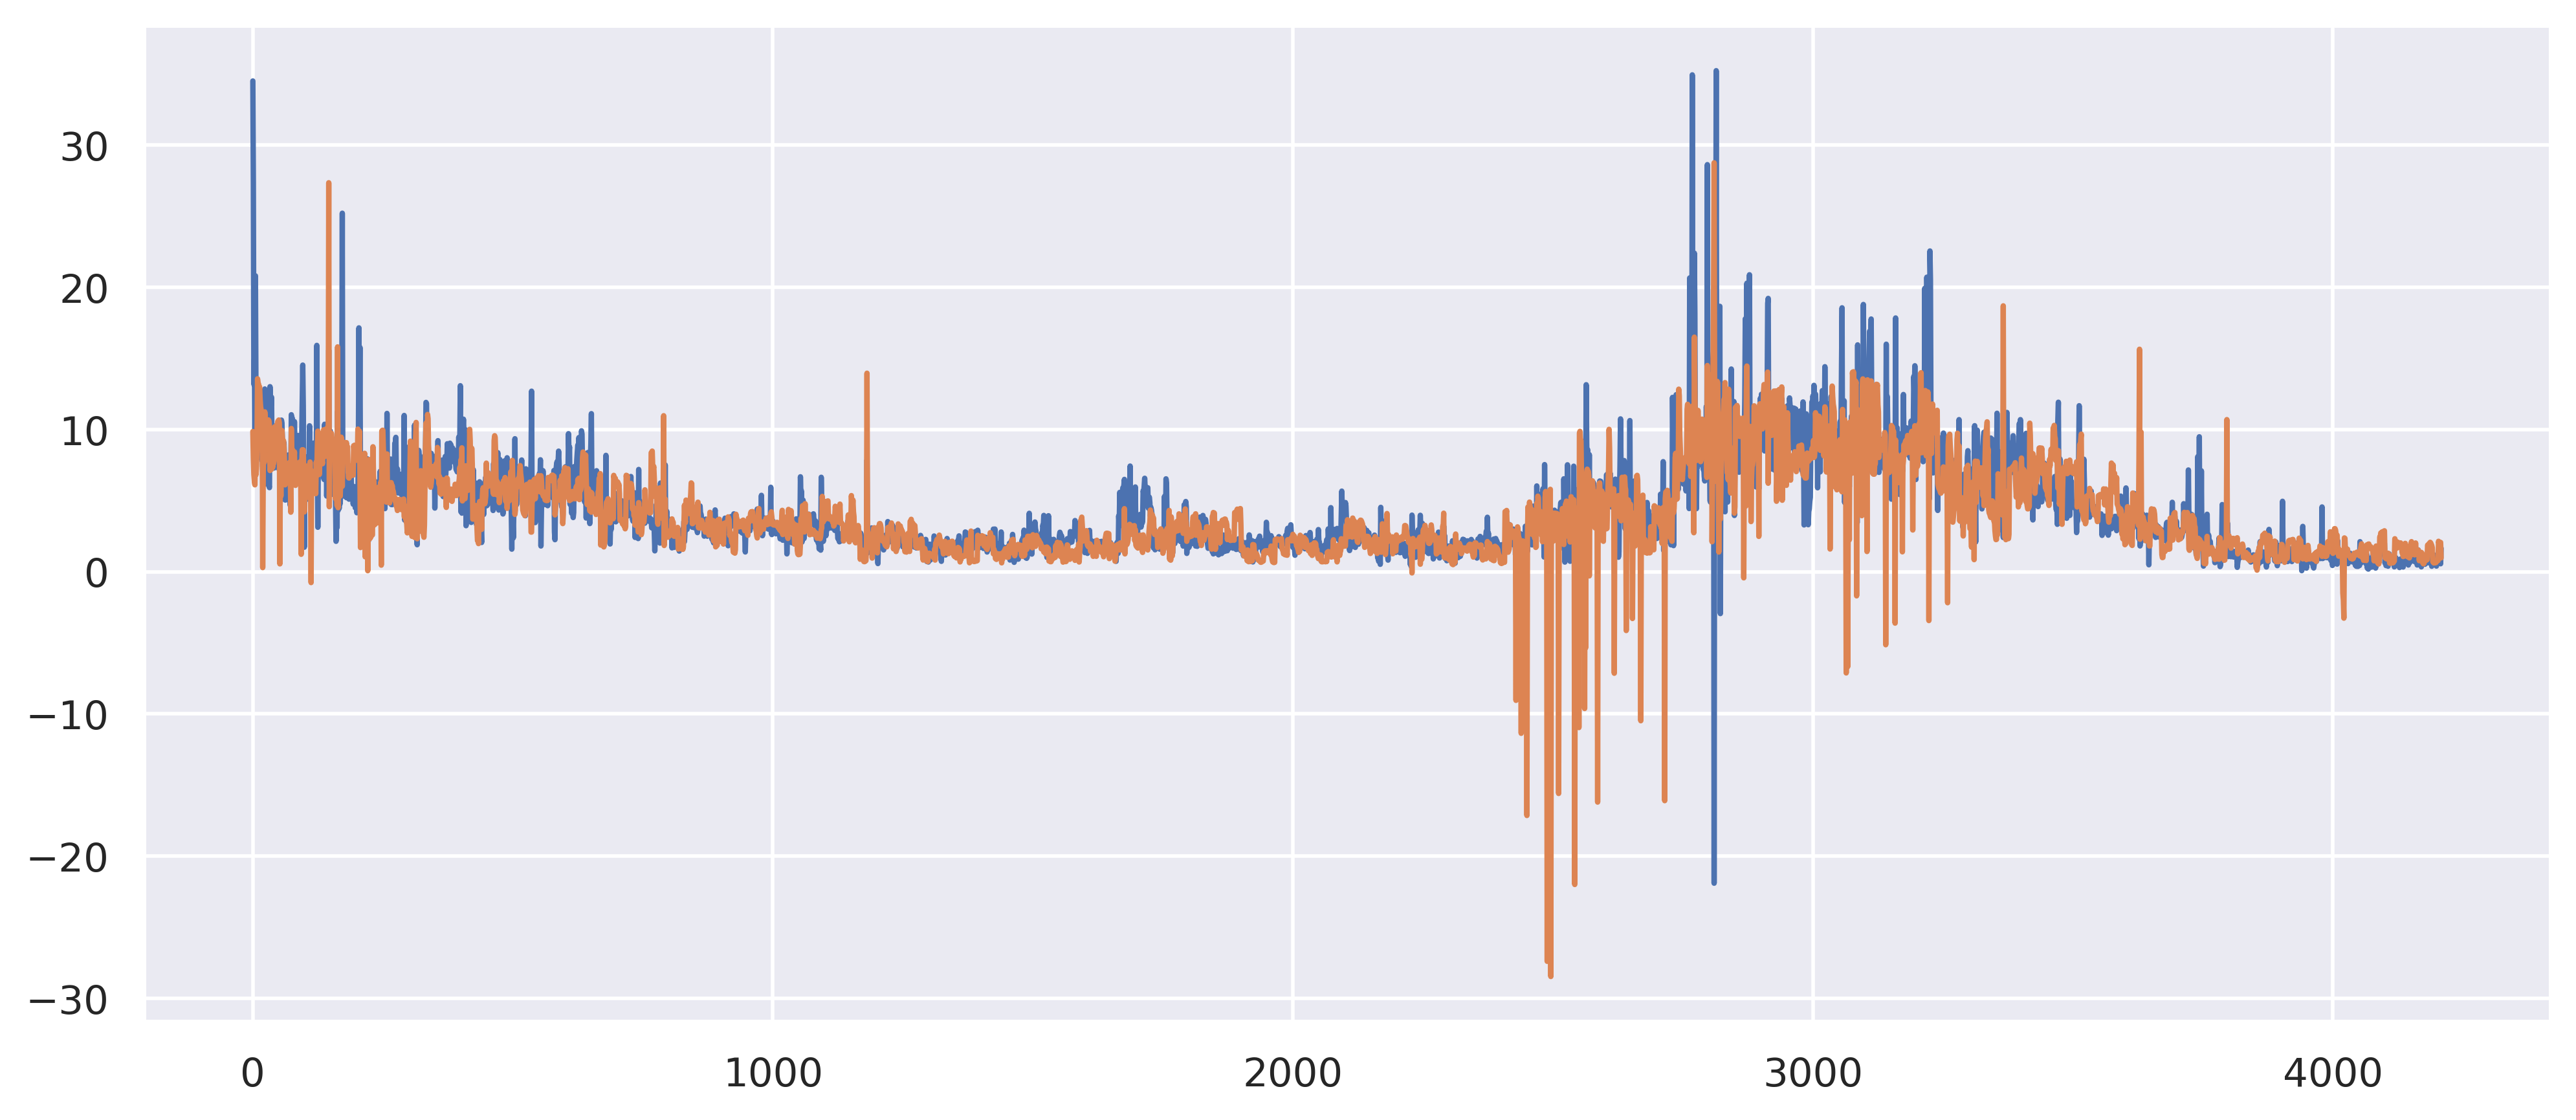

In [35]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt.nee)
ax.plot(preds.nee)
fig.savefig(save_dir.joinpath("nee_predictions.png"))

In [36]:
mask = (test_data["DateTime"].dt.month == 1).values

In [37]:
gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask]

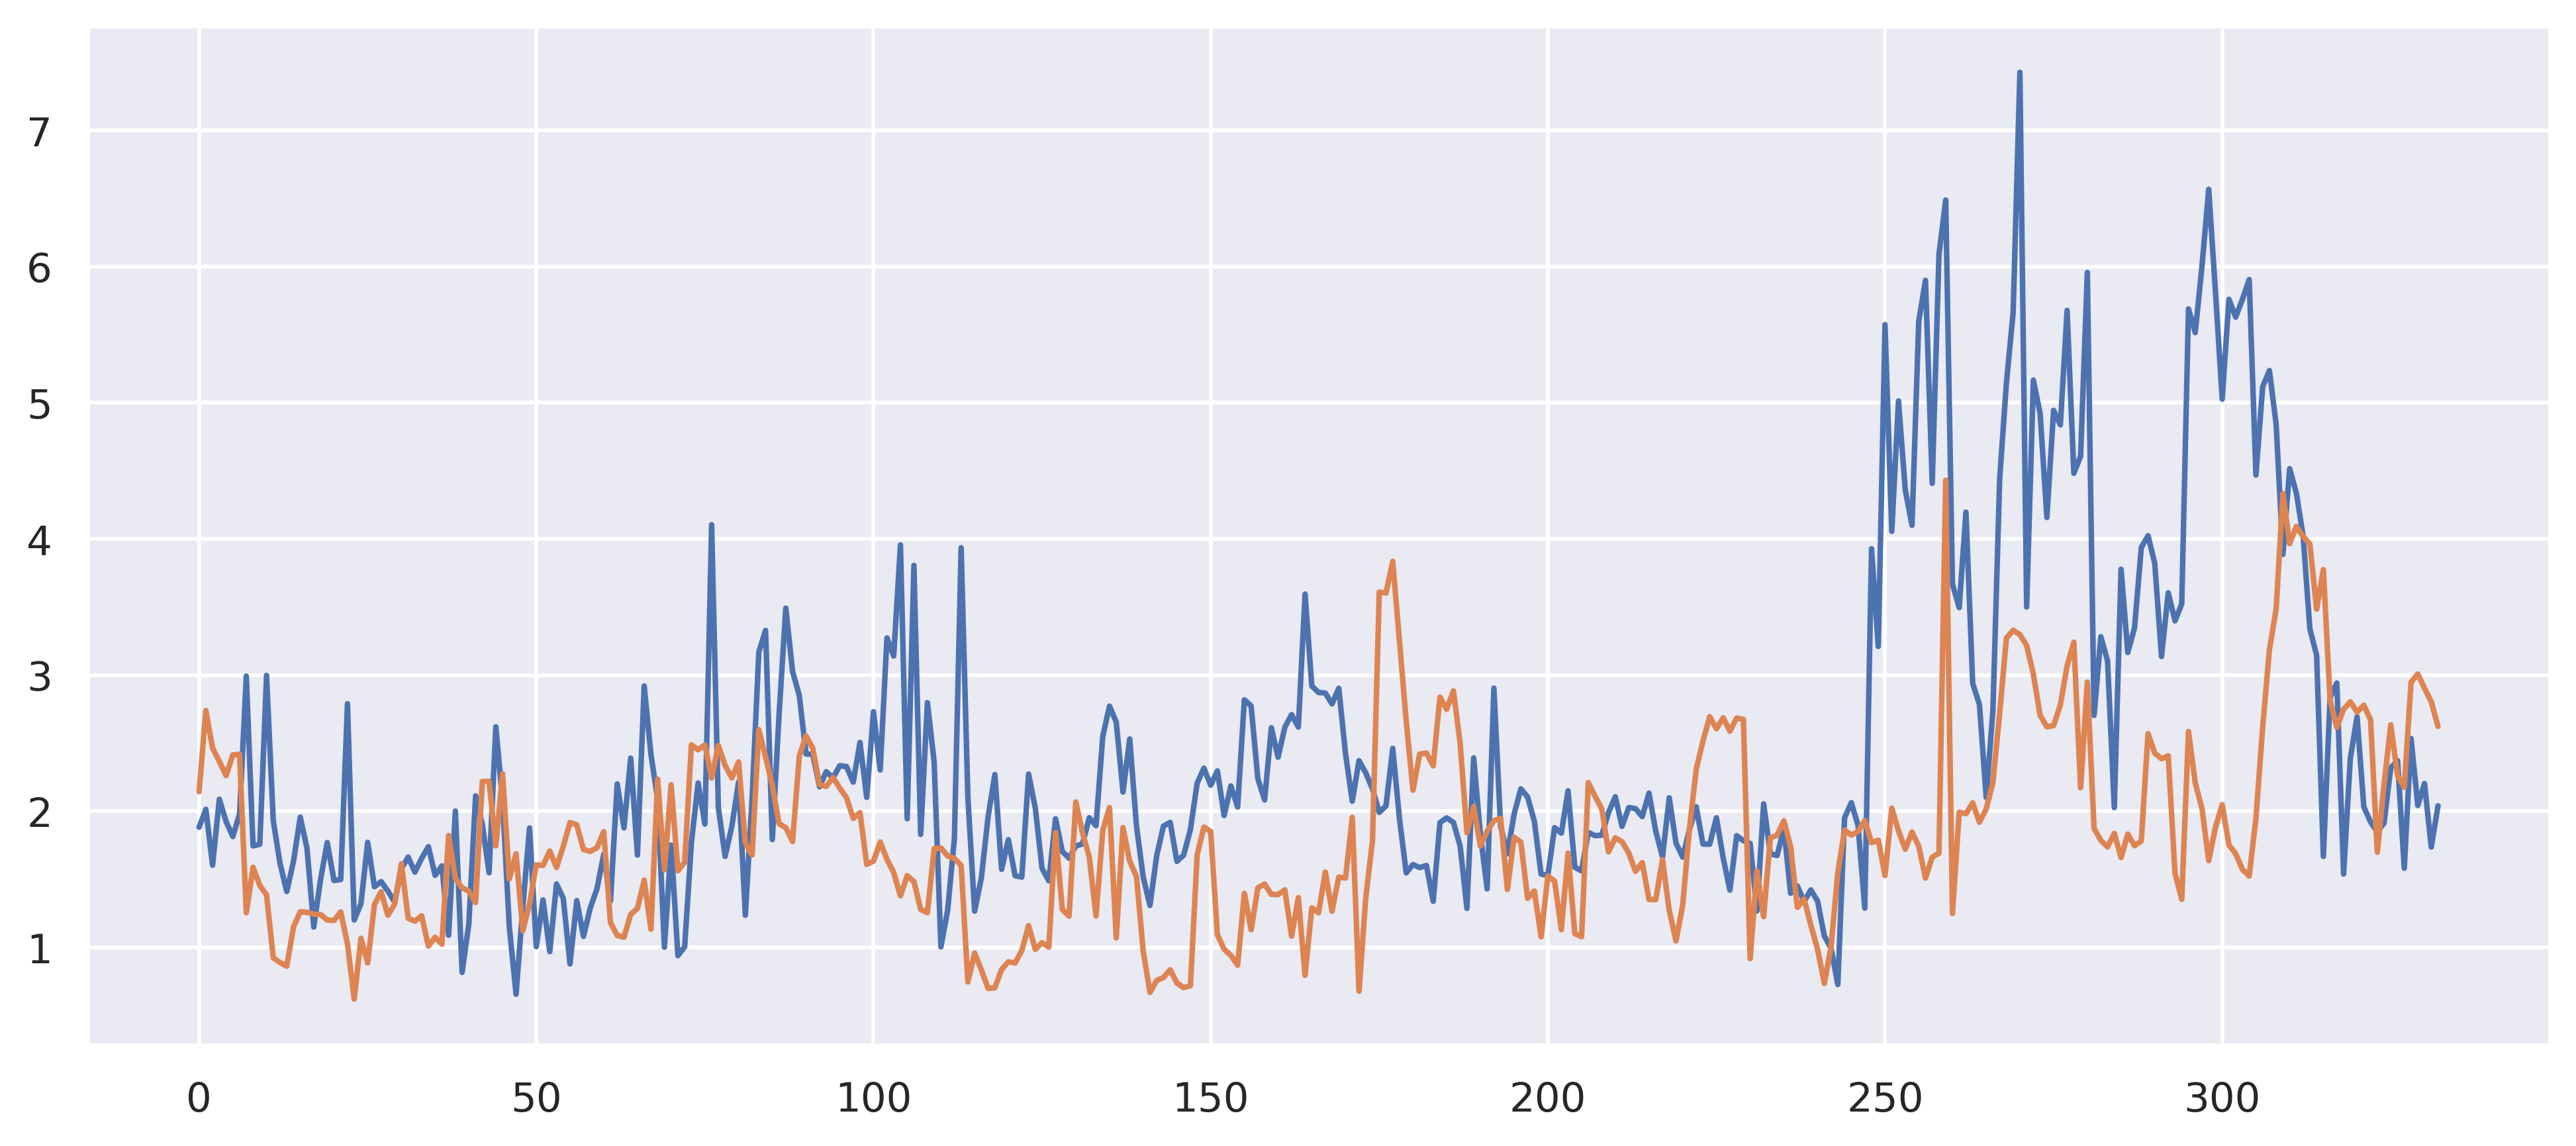

In [38]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis)
ax.plot(preds_vis)
fig.savefig(save_dir.joinpath("nee_predictions_month1.png"))

In [39]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfr.fit(X_train, NEE_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [40]:
preds_rfr = rfr.predict(X_test)
gt_rfr = NEE_test.values

In [41]:
mean_absolute_error(gt_rfr, preds_rfr), r2_score(gt_rfr, preds_rfr)


(1.1811439078641008, 0.645008537160097)

In [42]:
gt_rfr_vis = gt_rfr[mask]
preds_rfr_vis = preds_rfr[mask]

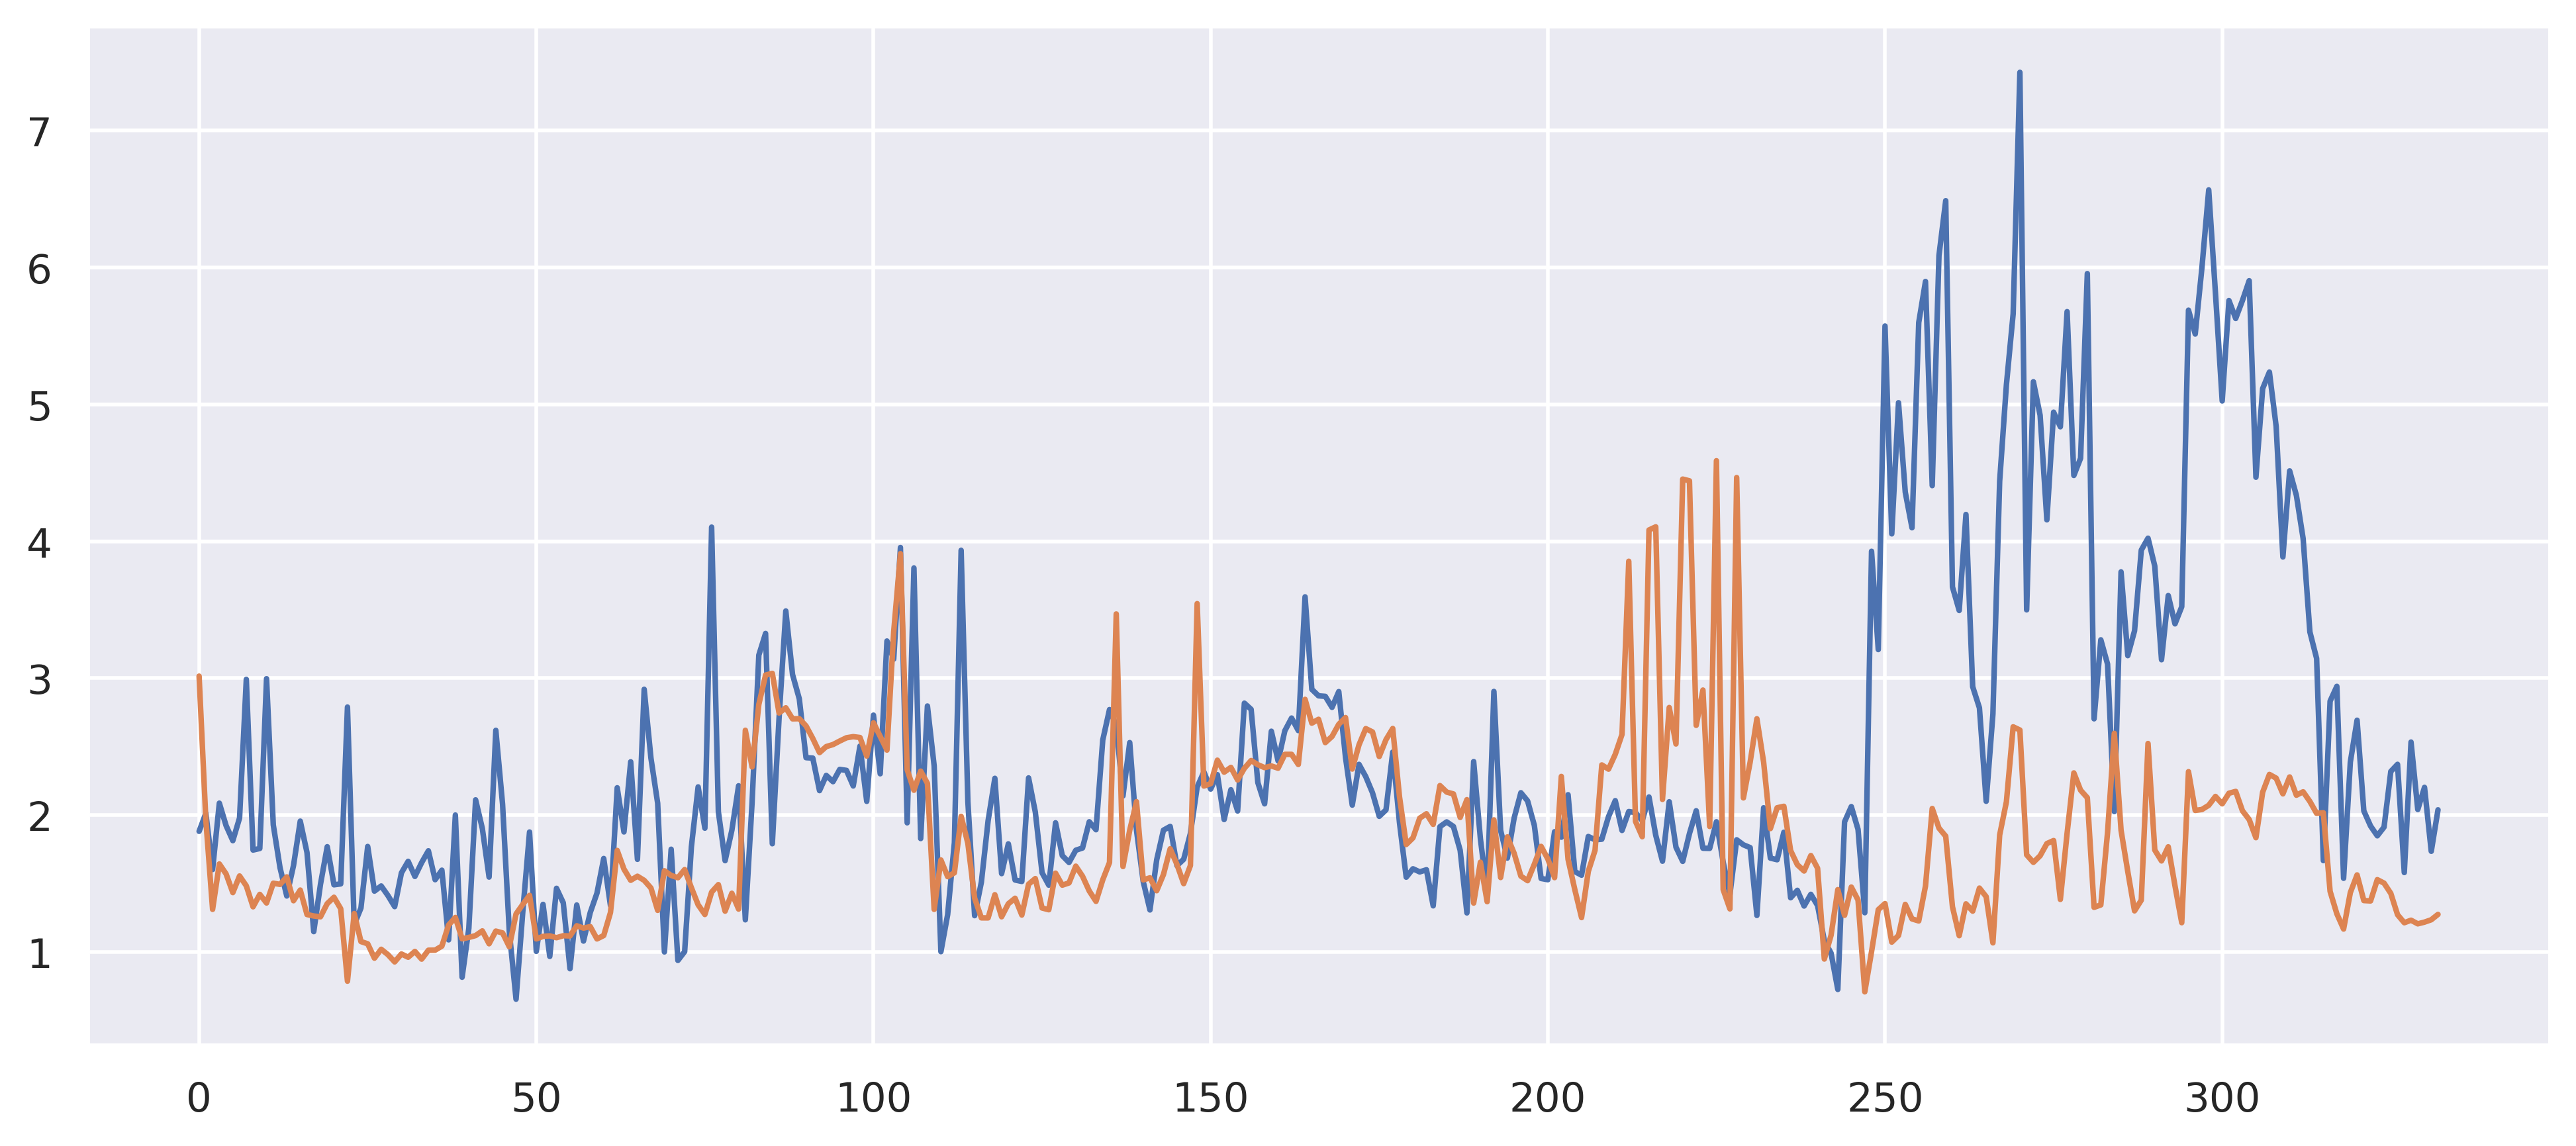

In [43]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
plt.plot(gt_rfr_vis)
plt.plot(preds_rfr_vis)

<BarContainer object of 15 artists>

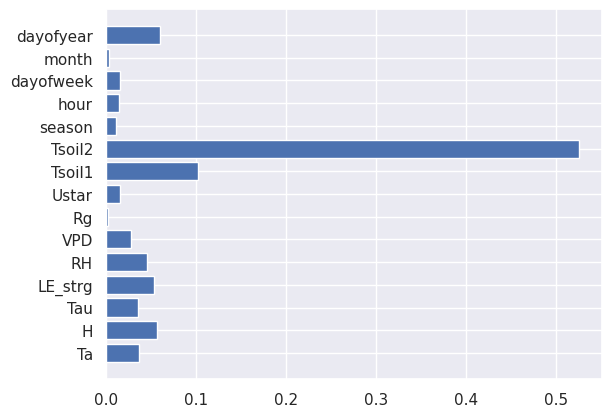

In [44]:
columns = drivers

plt.barh(columns, rfr.feature_importances_)